In [45]:
from numpy.random import seed
seed(8)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from sklearn import datasets, model_selection 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Input
from tensorflow.keras import regularizers

In [7]:
iris_data = datasets.load_iris()

In [69]:
def Divide_data(iris_data):
    input1 = iris_data["data"]
    target = iris_data["target"]
    input2 = (input1-input1.mean(axis=0))/input1.std(axis=0)
    return model_selection.train_test_split(input2,target,test_size=0.2)

In [78]:
X_train,X_test,y_train,y_test = Divide_data(iris_data)

In [79]:
y_train = tf.keras.utils.to_categorical(np.array(y_train))
y_test = tf.keras.utils.to_categorical(np.array(y_test))

In [80]:
pd.DataFrame(y_train)[0].unique()

array([0., 1.])

In [81]:
def compile(model):
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [87]:
def train(model,X_train,y_train,epochs):
    history = model.fit(X_train,y_train,epochs=epochs,validation_split=0.1,verbose=1)
    return history

In [88]:
def get_regularised_model(input_shape,dropout_rate,weight_decay):
    model=Sequential([
        Input(shape=input_shape),
        Dense(64,kernel_initializer="he_uniform",bias_initializer="ones"),
        Dense(128,kernel_regularizer=regularizers.l2(weight_decay),activation="relu"),
        Dense(128,kernel_regularizer=regularizers.l2(weight_decay),activation="relu"),
        Dropout(dropout_rate),
        Dense(128,kernel_regularizer=regularizers.l2(weight_decay),activation="relu"),
        Dense(128,kernel_regularizer=regularizers.l2(weight_decay),activation="relu"),
        Dense(64,kernel_regularizer=regularizers.l2(weight_decay),activation="relu"),
        Dense(64,kernel_regularizer=regularizers.l2(weight_decay),activation="relu"),
        Dropout(dropout_rate),
        Dense(64,kernel_regularizer=regularizers.l2(weight_decay),activation="relu"),
        Dense(64,kernel_regularizer=regularizers.l2(weight_decay),activation="relu"),
        Dense(3,activation="softmax")
    ])
    return model

In [89]:
reg_model = get_regularised_model(X_train[0].shape, 0.3, 0.001)

In [90]:
compile(reg_model)

In [91]:
hist = train(reg_model,X_train,y_train,epochs=800)

Epoch 1/800
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.4907 - loss: 1.8088 - val_accuracy: 0.5833 - val_loss: 1.6481
Epoch 2/800
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7222 - loss: 1.5754 - val_accuracy: 0.5833 - val_loss: 1.4199
Epoch 3/800
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6944 - loss: 1.2906 - val_accuracy: 0.5833 - val_loss: 1.2760
Epoch 4/800
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7037 - loss: 1.1755 - val_accuracy: 0.7500 - val_loss: 1.1705
Epoch 5/800
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7778 - loss: 1.0829 - val_accuracy: 0.7500 - val_loss: 1.0804
Epoch 6/800
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8426 - loss: 1.0320 - val_accuracy: 0.7500 - val_loss: 1.0380
Epoch 7/800
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9259 - loss: 0.8618 - val_accuracy: 1.0000 - val_loss: 0.8394
Epoch 8/800
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9167 - loss: 0.8385 - val_accuracy: 0.8333 - val_loss:

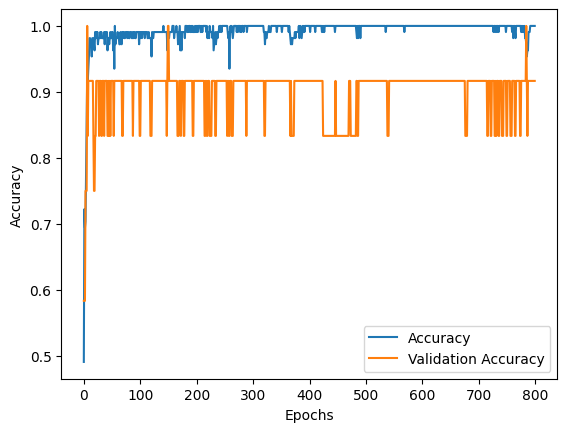

In [121]:
plt.plot(hist.history['accuracy'],label='acc')
plt.plot(hist.history['val_accuracy'],label='val_acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Accuracy','Validation Accuracy'],loc='lower right')

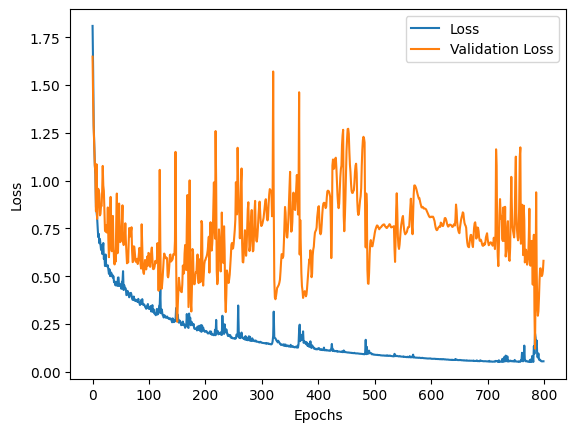

In [124]:
plt.plot(hist.history['loss'],label='loss')
plt.plot(hist.history['val_loss'],label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss','Validation Loss'],loc='upper right')

We can see its getting saturated after some certain epochs for training but for validation it's very random

##### I will use callbacks to automatically control training.
##### It will stop training when the model stops improving (on validation mainly)
##### and adjust the learning rate so the model learns better.
##### Early Stopping stops the model training when validation isnt increasing for {patience} epochs
##### Similarly Learning Rate Reduction will reduce LR if val doesnt improve for {patience} epochs

In [116]:
from tensorflow.keras.callbacks import Callback
def get_callbacks():
    early_stopping=tf.keras.callbacks.EarlyStopping(patience=30,mode="min"),
    learning_rate_reduction=tf.keras.callbacks.ReduceLROnPlateau(factor=0.2,patience=20)
    return early_stopping,learning_rate_reduction

In [128]:
call_model = get_regularised_model(X_train[0].shape, 0.3, 0.0001)
compile(call_model)
early_stopping,learning_rate_reduction = get_callbacks()
call_history = call_model.fit(X_train, y_train, epochs=800, validation_split=0.15,
                         callbacks=[*early_stopping, learning_rate_reduction], verbose=0)

In [133]:
learning_rate_reduction

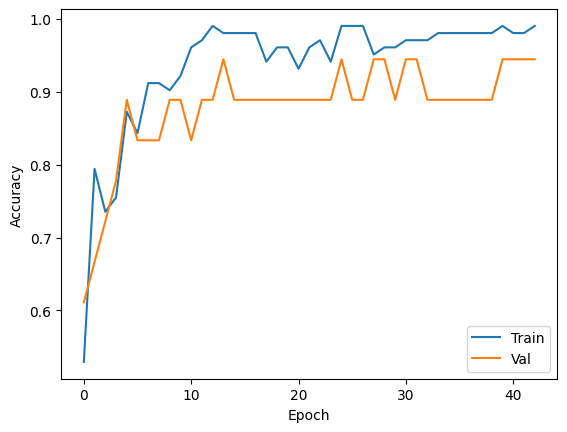

In [138]:
plt.plot(call_history.history['accuracy'])
plt.plot(call_history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

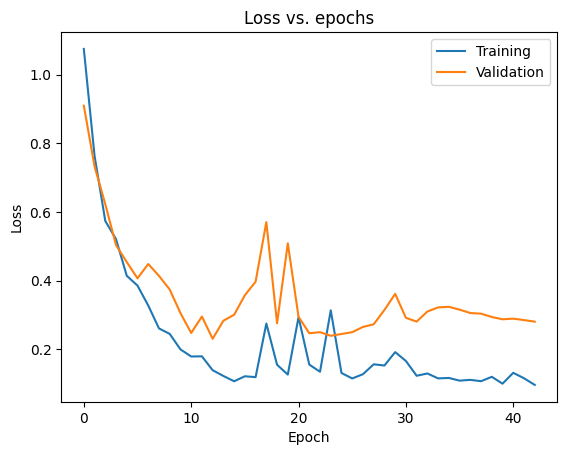

In [139]:
plt.plot(call_history.history['loss'])
plt.plot(call_history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [141]:
test_loss, test_acc = call_model.evaluate(X_test, y_test, verbose=2)
print("Test loss: {:.3f}\nTest accuracy: {:.2f}%".format(test_loss, 100 * test_acc))

1/1 - 0s - 17ms/step - accuracy: 0.9667 - loss: 0.1388
Test loss: 0.139
Test accuracy: 96.67%


## 96.67% Lessgooo

### Sufficient So I will stop here